In [1]:
# transformer plus evolutionary algorithms: learning some wave rules
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from deap import base, creator, tools, algorithms
import random

from wavefn import WaveFunction

# Hyperparameters
batch_size = 8
block_size = 16
max_iter = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = 12  # Assuming this is correct based on your original tokens

tokens = ['0','1','2','3','4','5','6','7','8','9','s','e']
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[str(c)] for c in s]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')

# Wave generation functions (from your original code)
def generate_random_wave_profile(size):
    return ((np.random.rand(size)*10).astype(int))

def simulate_wave_sequence(batch_size, size):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        transformed_profile = wave_fn.simulate_wave_equation(profile)
        # Remove clipping to allow for more variation
        transformed_profile_as_str = 's' + ''.join(map(lambda x: str(int(x) % 10), transformed_profile.tolist())) + 'e'
        final_profiles.append(transformed_profile_as_str)
    return initial_profiles, final_profiles

def get_batch(batch_size, size, block_size):
    initial_profiles, final_profiles = simulate_wave_sequence(batch_size, size)
    X = torch.tensor([enc('s' + ''.join(map(str, profile)) + 'e')[:block_size] for profile in initial_profiles], dtype=torch.long)
    Y = torch.tensor([enc(profile)[:block_size] for profile in final_profiles], dtype=torch.long)
    return X.to(device), Y.to(device)

def decode_model_output(logits):
    # Convert logits to probabilities and get the most likely token
    probs = F.softmax(logits, dim=-1)
    predicted_tokens = torch.argmax(probs, dim=-1)
    
    # Decode the predicted tokens
    decoded_outputs = []
    for sequence in predicted_tokens:
        decoded_sequence = dec(sequence.tolist())
        decoded_outputs.append(decoded_sequence)
    
    return decoded_outputs

class CoPEPositionalEmbedding(nn.Module):
    def __init__(self, n_embed, max_len):
        super().__init__()
        self.fc = nn.Linear(n_embed, n_embed)

    def forward(self, tok_emb):
        seq_len = tok_emb.size(1)
        position_indices = torch.arange(seq_len, device=tok_emb.device).unsqueeze(0).repeat(tok_emb.size(0), 1)
        position_encoded = self.fc(tok_emb + self.fc(position_indices.float().unsqueeze(-1).expand(-1, -1, tok_emb.size(-1))))
        return position_encoded

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        self.sa = nn.MultiheadAttention(n_embed, n_head)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed)
        )
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.ffwd(self.ln2(x))
        return x

class SmallLLM(nn.Module):
    def __init__(self, vocab_size, n_embed, n_head, n_layer):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = CoPEPositionalEmbedding(n_embed, block_size)
        self.blocks = nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(tok_emb)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

class LLMEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)) / len(models))

    def forward(self, idx):
        outputs = [model(idx) for model in self.models]
        weighted_sum = sum(w * out for w, out in zip(self.weights, outputs))
        return weighted_sum

# Evolutionary Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def generate_random_architecture():
    return {
        'n_embed': random.choice([32, 48, 64, 80, 96, 112, 128, 144, 160]),
        'n_head': random.choice([1, 2, 4, 8]),
        'n_layer': random.choice([1, 2, 4, 8])
    }

def mutate(individual):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = generate_random_architecture()
    return individual,

def mate(ind1, ind2):
    return tools.cxTwoPoint(ind1, ind2)

def evaluate(individual):
    models = [SmallLLM(vocab_size, **arch) for arch in individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-4)
    
    total_loss = 0
    for _ in range(10):  # Short training
        xb, yb = get_batch(batch_size, 64, block_size)
        logits = ensemble(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return (1 / (total_loss / 10),)  # Return fitness (higher is better)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual, generate_random_architecture, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

def custom_loss(predictions, targets, vocab_size):
    ce_loss = F.cross_entropy(predictions.view(-1, vocab_size), targets.view(-1))
    zero_penalty = torch.mean(torch.abs(predictions[:, :, 0]))  # Penalize predicting zero
    return ce_loss + 0.1 * zero_penalty

def diversity_loss(ensemble_outputs):
    mean_output = torch.mean(ensemble_outputs, dim=0)
    return -torch.mean(torch.abs(ensemble_outputs - mean_output))

def train_best_ensemble(best_individual, epochs=5):
    models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

    val_batch_size = batch_size
    max_norm = 1
    eval_interval = 500

    for epoch in range(epochs):
        total_loss = 0
        for iter in range(max_iter // epochs):
            ensemble.train()
            xb, yb = get_batch(batch_size, 64, block_size)
            
            # Get individual model outputs
            individual_outputs = [model(xb) for model in ensemble.models]
            
            # Compute ensemble output
            ensemble_output = ensemble(xb)
            
            # Compute custom loss
            custom_loss_value = custom_loss(ensemble_output, yb, vocab_size)
            
            # Compute diversity loss
            div_loss_value = diversity_loss(torch.stack(individual_outputs))
            
            # Combine losses
            loss = custom_loss_value + 0.1 * div_loss_value  # You can adjust this weight

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ensemble.parameters(), max_norm)
            optimizer.step()
            total_loss += loss.item()

            if iter % eval_interval == 0:
                ensemble.eval()
                with torch.no_grad():
                    xv, yv = get_batch(val_batch_size, 64, block_size)
                    val_logits = ensemble(xv)
                    val_loss = custom_loss(val_logits, yv, vocab_size)
                    print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
                    
                    # Decode and print examples
                    input_decoded = [dec(seq.tolist()) for seq in xv[:3]]
                    target_decoded = [dec(seq.tolist()) for seq in yv[:3]]
                    predicted_decoded = decode_model_output(val_logits[:3])
                    
                    # print("Input examples:", input_decoded)
                    # print("Target examples:", target_decoded)
                    # print("Predicted examples:", predicted_decoded)
                
                ensemble.train()

        avg_loss = total_loss / (max_iter // epochs)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")
        scheduler.step(avg_loss)

    return ensemble

def main():
    global best_individual
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)

    print("Evolution complete")
    best_individual = hof[0]
    print("Best individual:", best_individual)

    print("Training best ensemble...")
    best_ensemble = train_best_ensemble(best_individual)
    
    print("Training complete")
    return best_ensemble

if __name__ == "__main__":
    # Initialize WaveFunction (assuming this is from your original code)
    wave_length = 16
    c = 1.0
    dx = 0.1
    dt = 0.1
    wave_fn = WaveFunction(c, dx, dt)

    # Run the evolutionary process and train the best ensemble
    best_model = main()

    # Save the model
    torch.save(best_model.state_dict(), 'models/best_evolutionary_ensemble.pth')
    print("Model saved as 'best_evolutionary_ensemble.pth'")

gen	nevals	avg     	min     	max     
0  	50    	0.414987	0.403309	0.424344
1  	35    	0.419031	0.404308	0.429246
2  	36    	0.422977	0.412044	0.432616
3  	38    	0.425183	0.414999	0.435192
4  	41    	0.426854	0.416109	0.435583
5  	38    	0.427984	0.412104	0.436312
6  	37    	0.428719	0.413058	0.435351
7  	33    	0.429016	0.420082	0.435888
8  	41    	0.429219	0.421251	0.437177
9  	42    	0.429693	0.418712	0.437177
10 	37    	0.430804	0.415722	0.437177
Evolution complete
Best individual: [{'n_embed': 96, 'n_head': 4, 'n_layer': 8}, {'n_embed': 160, 'n_head': 2, 'n_layer': 8}, {'n_embed': 144, 'n_head': 2, 'n_layer': 8}, {'n_embed': 160, 'n_head': 4, 'n_layer': 4}, {'n_embed': 144, 'n_head': 2, 'n_layer': 8}]
Training best ensemble...
Epoch 0, Iteration 0: Training Loss = 2.480733871459961, Validation Loss = 2.4365322589874268
Input examples: ['32685011603871', '58967911165604', '84281039775957']
Target examples: ['28432685011603', '69458967911165', '45084281039775']
Predicted examples: 

Input wave: [3 9 7 5 1 1 0 8 6 7 0 9 8 2 1 1]
Ensemble weights: [0.1972213  0.23738602 0.19991845 0.2241829  0.19438876]
Weight distribution: (array([2, 1, 0, 0, 0, 0, 1, 0, 0, 1]), array([0.19438876, 0.19868849, 0.2029882 , 0.20728794, 0.21158767,
       0.2158874 , 0.22018711, 0.22448684, 0.22878657, 0.23308629,
       0.23738602], dtype=float32))
Token distribution:
  9: 0.1124
  5: 0.1106
  6: 0.1033
  7: 0.0968
  2: 0.0932
  3: 0.0907
  8: 0.0863
  0: 0.0862
  1: 0.0826
  4: 0.0801
  s: 0.0555
  e: 0.0022
Wavefn output: [2 1 1 3 9 7 5 1 1 0 8 6 7 0 9 8]

Sampling method: argmax
Logits shape: torch.Size([1, 18, 12])
Logits mean: -1.435486912727356
Logits std: 4.504075527191162
Top 5 probable tokens at position 0:
  Token: s, Probability: 0.9997
  Token: e, Probability: 0.0001
  Token: 7, Probability: 0.0000
  Token: 6, Probability: 0.0000
  Token: 3, Probability: 0.0000
Top 5 probable tokens at position 1:
  Token: 5, Probability: 0.1182
  Token: 9, Probability: 0.1179
  Token: 6, 

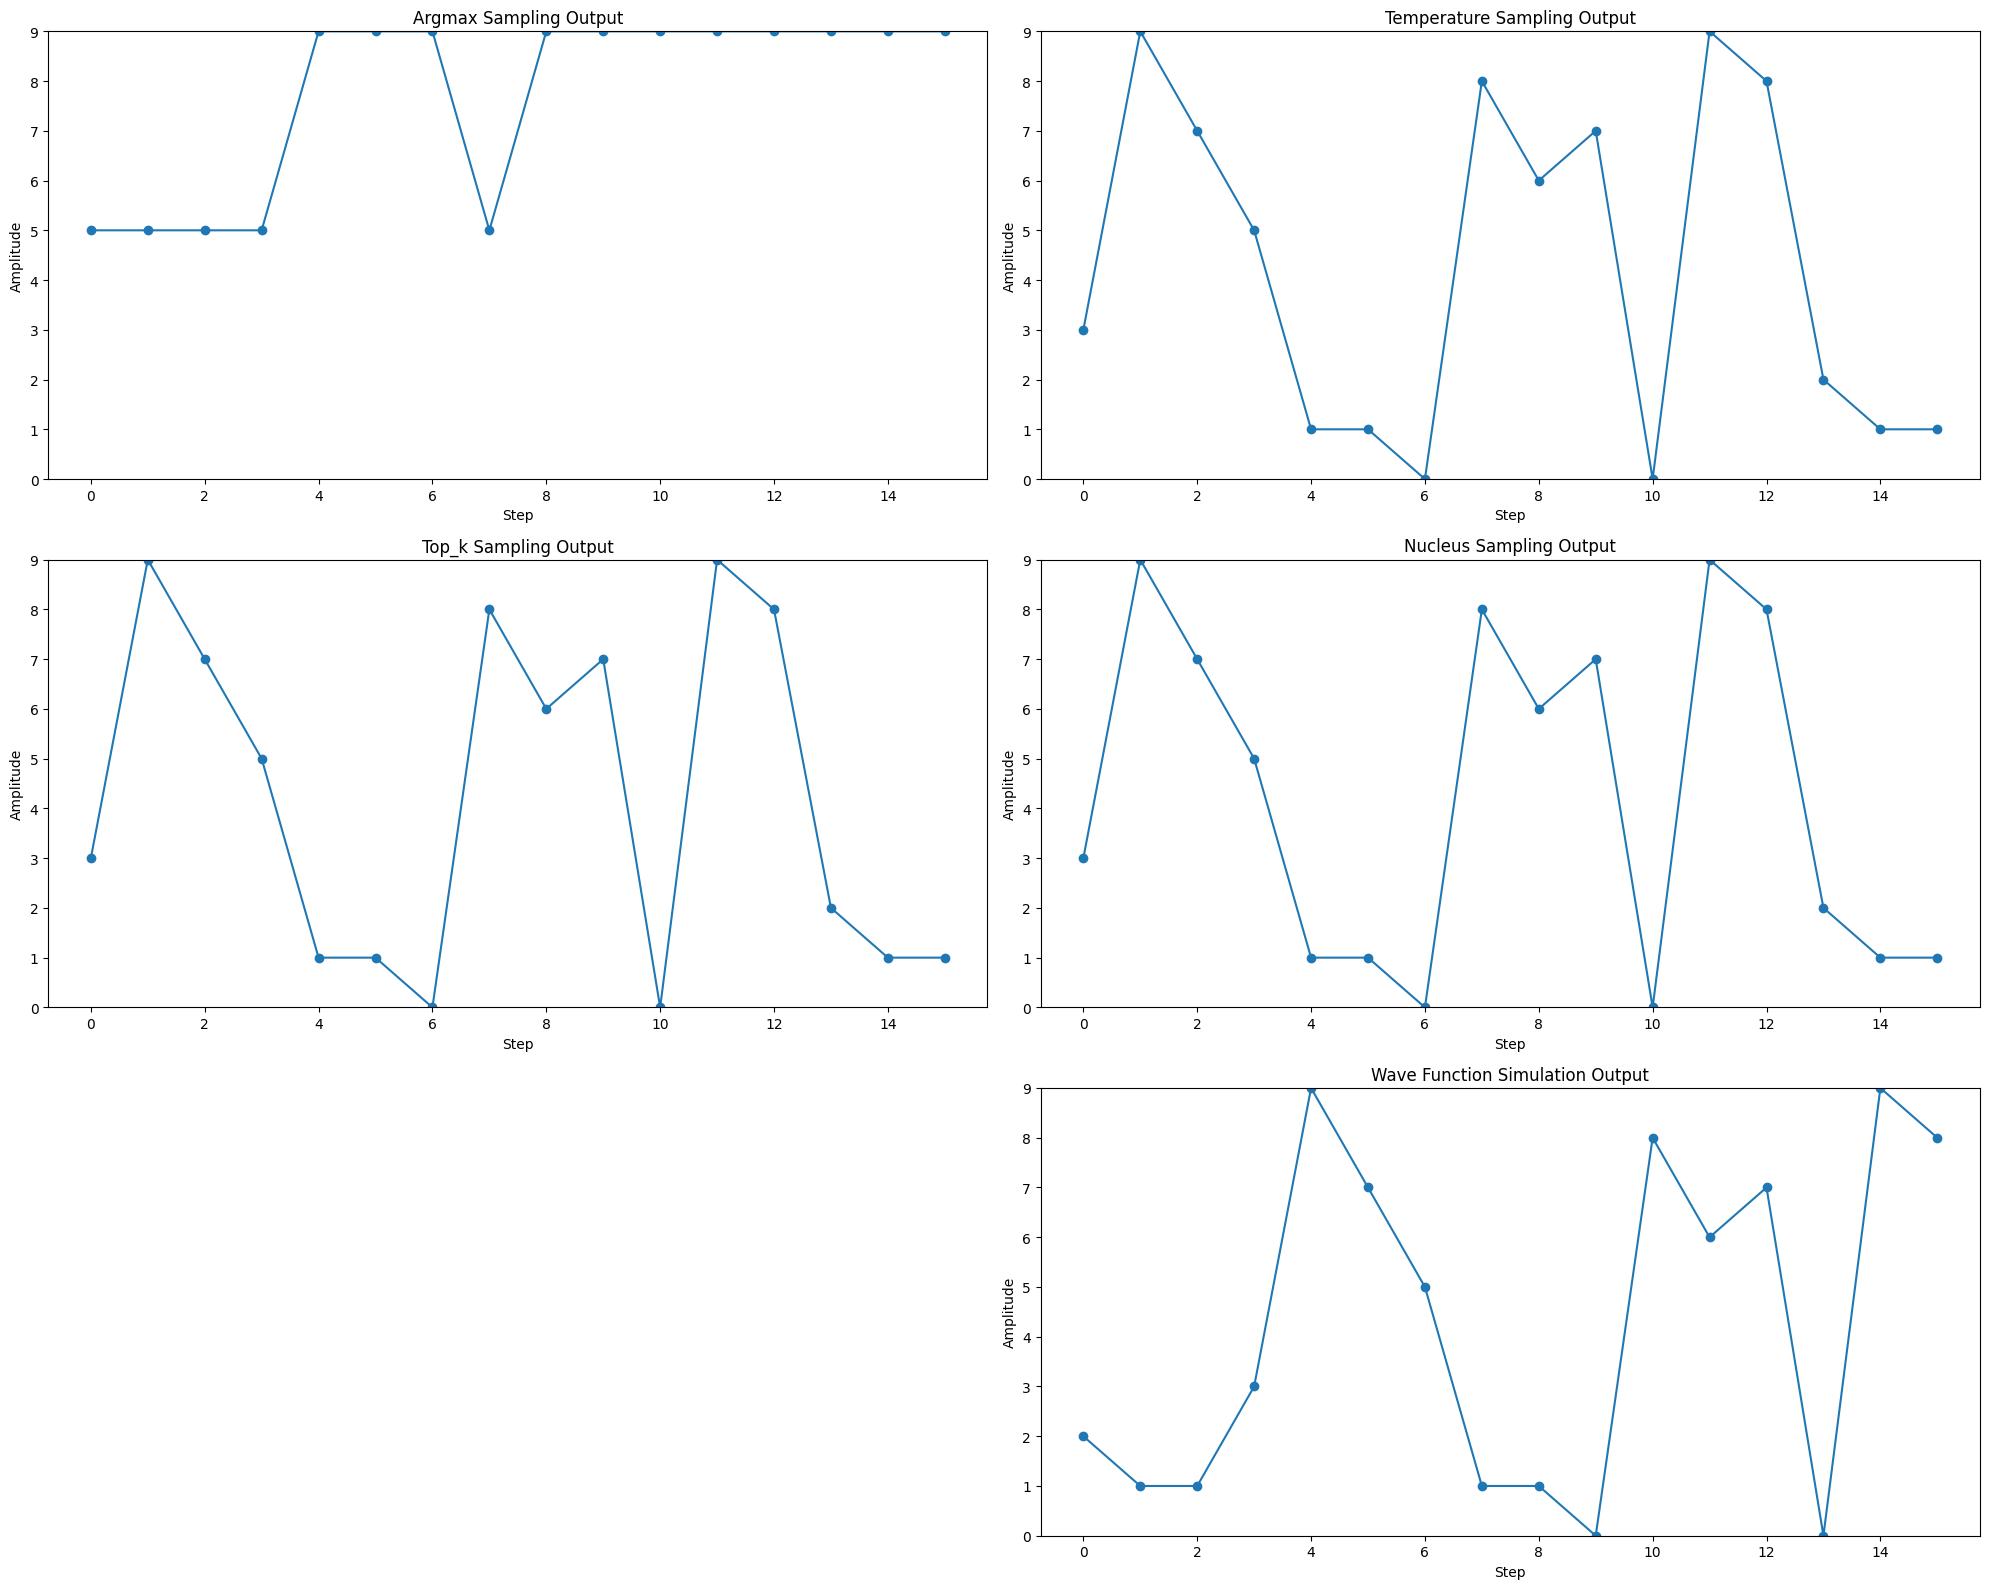

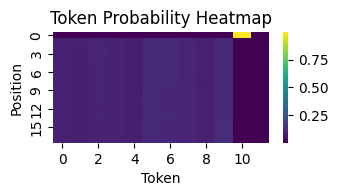

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

# Sampling functions
def temperature_sampling(logits, temperature=0.7):  # Lowered from 1.0
    probs = F.softmax(logits / temperature, dim=-1)
    return torch.multinomial(probs, num_samples=1)

def calculate_accuracy(predicted, ground_truth):
    correct = sum(p == g for p, g in zip(predicted, ground_truth))
    return correct / len(ground_truth)

def top_k_sampling(logits, k=50):
    top_k = torch.topk(logits, k)
    indices_to_remove = logits < top_k.values[..., -1, None]
    logits[indices_to_remove] = float('-inf')
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1)

def nucleus_sampling(logits, p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)
    logits[indices_to_remove] = float('-inf')
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1)

def generate_output(model, input_tensor, max_length=18, sampling_method='temperature', **kwargs):
    generated = input_tensor
    for _ in range(max_length - input_tensor.size(1)):
        with torch.no_grad():
            logits = model(generated)[:, -1, :]
            if sampling_method == 'temperature':
                next_token = temperature_sampling(logits, temperature=kwargs.get('temperature', 0.8))
            elif sampling_method == 'top_k':
                next_token = top_k_sampling(logits, k=kwargs.get('k', 50))
            elif sampling_method == 'nucleus':
                next_token = nucleus_sampling(logits, p=kwargs.get('p', 0.9))
            else:
                next_token = torch.argmax(logits, dim=-1).unsqueeze(0)
        generated = torch.cat((generated, next_token), dim=1)
    return generated

# Load the model (assuming this part is correct)
models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
model = LLMEnsemble(models).to(device)
model.load_state_dict(torch.load('models/best_evolutionary_ensemble.pth'))
model.eval()

# Generate input
np.random.seed(42)  # Seed for reproducibility
input_length = 16
input_wave = generate_random_wave_profile(input_length)
print(f"Input wave: {input_wave}")

# Encode input with start and end tokens
encoded_input = enc('s' + ''.join(map(str, input_wave)) + 'e')
input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)
        
def analyze_token_distribution(logits):
    probs = F.softmax(logits, dim=-1)
    token_dist = probs.mean(dim=(0, 1)).cpu().numpy()
    print("Token distribution:")
    for token, prob in sorted(zip(itos.values(), token_dist), key=lambda x: x[1], reverse=True):
        print(f"  {token}: {prob:.4f}")

# After loading the model
ensemble_weights = model.weights.detach().cpu().numpy()
print("Ensemble weights:", ensemble_weights)
print("Weight distribution:", np.histogram(ensemble_weights))
analyze_token_distribution(logits)

# Simulate wave using the original input
sim_wave_output = wave_fn.simulate_wave_equation(input_wave)
print("Wavefn output:", sim_wave_output)

# Generate output using different sampling methods
sampling_methods = ['argmax', 'temperature', 'top_k', 'nucleus']
outputs = {}

for method in sampling_methods:
    with torch.no_grad():
        if method == 'argmax':
            logits = model(input_tensor)
            probs = F.softmax(logits, dim=-1)
            predicted_tokens = torch.argmax(probs, dim=-1)
        else:
            predicted_tokens = generate_output(model, input_tensor, sampling_method=method)

        print(f"\nSampling method: {method}")
        print("Logits shape:", logits.shape)
        print("Logits mean:", logits.mean().item())
        print("Logits std:", logits.std().item())

        # Print probabilities for the first few positions
        for i in range(5):
            print(f"Top 5 probable tokens at position {i}:")
            top_probs, top_indices = torch.topk(probs[0, i], 5)
            for prob, idx in zip(top_probs, top_indices):
                print(f"  Token: {itos[idx.item()]}, Probability: {prob.item():.4f}")

        # Decode the entire output, including start and end tokens
        decoded_output = ''.join([itos[i] for i in predicted_tokens[0].tolist()])
        print("Raw decoded output:", decoded_output)

        # Extract the actual wave values (remove 's' and 'e', and convert to integers)
        generated_output = [int(char) for char in decoded_output[1:-1] if char.isdigit()]
        print("Generated output:", generated_output)
        
        # Calculate and print accuracy
        accuracy = calculate_accuracy(generated_output, sim_wave_output)
        print(f"Accuracy: {accuracy:.2f}")

        outputs[method] = generated_output

# Plotting
plt.figure(figsize=(20, 16))

# Plot for each sampling method
for i, (method, output) in enumerate(outputs.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(output, marker='o', linestyle='-')
    plt.title(f'{method.capitalize()} Sampling Output')
    plt.xlabel('Step')
    plt.ylabel('Amplitude')
    plt.ylim(0, 9)

# Plot for the Wave Function Simulation Output
plt.subplot(3, 2, 6)
plt.plot(sim_wave_output, marker='o', linestyle='-')
plt.title('Wave Function Simulation Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(0, 9)

plt.tight_layout()
plt.show()

# Add heatmap of token probabilities
plt.subplot(3, 2, 5)
sns.heatmap(probs[0].cpu().numpy(), cmap='viridis')
plt.title('Token Probability Heatmap')
plt.xlabel('Token')
plt.ylabel('Position')

plt.tight_layout()
plt.show()